### _in silico_ perturbation by cell type prompting

In [1]:
import os
import torch
import warnings
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt

# for flex attention
import torch._dynamo
torch._dynamo.config.suppress_errors = True

DEVICE = torch.device('cuda:0')
sc.set_figure_params(figsize=(4, 4))

from cellarium.ml.utilities.inference.cellarium_gpt_inference import \
    CellariumGPTInferenceContext, \
    GeneNetworkAnalysisBase

In [2]:
ROOT_PATH = "/home/mehrtash/data"
CHECKPOINT_PATH = "/home/mehrtash/data/100M_long_run/run_001/lightning_logs/version_3/checkpoints/epoch=5-step=504000.ckpt"
REF_ADATA_PATH = os.path.join(ROOT_PATH, "data", "extract_0.h5ad")
GENE_INFO_PATH = os.path.join(ROOT_PATH, "gene_info", "gene_info.tsv")

ctx = CellariumGPTInferenceContext(
    cellarium_gpt_ckpt_path=CHECKPOINT_PATH,
    ref_adata_path=REF_ADATA_PATH,
    gene_info_tsv_path=GENE_INFO_PATH,
    device=DEVICE,
    attention_backend="mem_efficient"
)

/opt/conda/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [96]:
# arguments
query_gene_ids = ctx.model_var_names
assay = "10x 3' v2"
suspension_type = "cell"
prompt_metadata_dict = {
    "cell_type": "CD8-positive, alpha-beta T cell",
    "tissue": "blood"
}
total_mrna_umis = 20_000

### Gene expression dynamic range determination

In [97]:
query_chunk_size = 5_000
upper_percentile = 0.99
upper_pad = 1

gene_expr_range_q = ctx.predict_gene_expression_dynamic_range_for_metadata(
    assay=assay,
    suspension_type=suspension_type,
    prompt_metadata_dict=prompt_metadata_dict,
    total_mrna_umis=total_mrna_umis,
    query_gene_ids=query_gene_ids,
    query_chunk_size=query_chunk_size,
    upper_percentile=upper_percentile,
    upper_pad=upper_pad
)

Processing gene chunks:   0%|          | 0/8 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/opt/conda/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
2025-02-07 23:38:42,491 - cellarium.ml.utilities.inference.cellarium_gpt_inference - INFO - Transferring the tokens to the device ...
2025-02-07 23:38:42,492 - cellarium.ml.utilities.inference.cellarium_gpt_inference - INFO - Done.
2025-02-07 23:38:42,493 - cellarium.ml.utilities.inference.cellarium_gpt_inference - INFO - Predicting ...
2025-02-07 23:38:42,517 - cellarium.ml.utilities.inference.cellarium_gpt_inference - INFO - Done.
2025-02-07 23:38:42,518 - cellarium.ml.utilities.inference.cellarium_gpt_inference - INFO - Calculating marginal mean and std ...
2025-02-07 23:38:42,518 - c

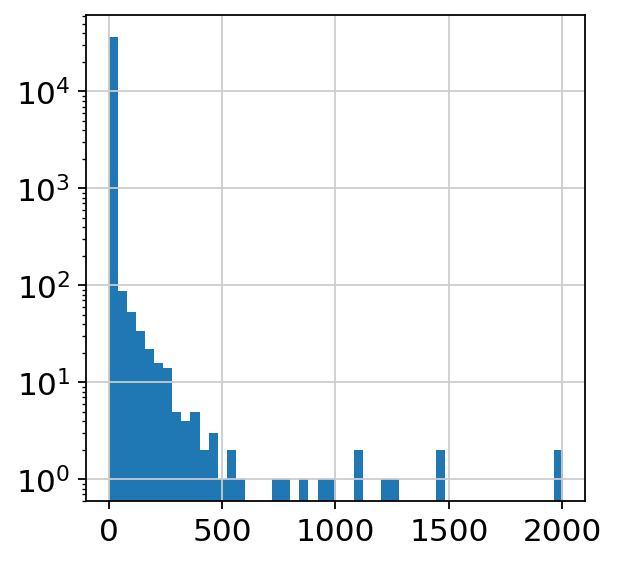

In [98]:
plt.hist(gene_expr_range_q.cpu().numpy(), bins=50, log=True);

In [99]:
for idx in torch.where(gene_expr_range_q > 1000)[0]:
    print(f"{ctx.model_var_names[idx]}: {gene_expr_range_q[idx]}, {ctx.gene_id_to_gene_symbol_map[ctx.model_var_names[idx]]}")

ENSG00000206172: 1090, HBA1
ENSG00000251562: 2001, MALAT1
ENSG00000211677: 1273, IGLC2
ENSG00000198804: 1206, MT-CO1
ENSG00000087086: 1470, FTL
ENSG00000211895: 1472, IGHA1
ENSG00000211592: 2001, IGKC
ENSG00000229117: 1110, RPL41
